# Installation Setup

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [141]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [142]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [143]:
df_merged = pd.read_csv('data/merged.csv')
stock_dimension = len(df_merged.tic.unique())
df_merged

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,FNB,10629,2007-01-03,-0.732,3,XLF,18.340,0.007,-0.027,-0.050,-0.029,18.250,18.790,18.200,8.567,282800,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,0.000
1,FNB,10629,2007-01-04,0.167,3,XLF,18.460,-0.031,-0.023,-0.042,-0.036,18.330,18.500,18.080,8.623,168900,3,0.001,8.675,8.516,100.000,-66.667,100.000,8.595,8.595,0.000
2,FNB,10629,2007-01-05,0.852,3,XLF,17.880,0.010,0.008,-0.025,-0.018,17.980,18.350,17.850,8.353,170000,4,-0.007,8.801,8.228,16.666,-100.000,100.000,8.514,8.514,0.000
3,FNB,10629,2007-01-08,-0.037,3,XLF,18.050,-0.004,-0.020,-0.023,-0.014,17.840,18.150,17.600,8.432,204700,0,-0.007,8.742,8.246,33.476,-91.050,100.000,8.494,8.494,0.000
4,FNB,10629,2007-01-09,0.627,3,XLF,17.980,-0.007,-0.018,-0.010,-0.004,18.050,18.050,17.630,8.399,143600,1,-0.009,8.706,8.244,30.827,-79.596,100.000,8.475,8.475,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,JKHY,88664,2021-12-27,0.166,2,XLK,165.550,0.011,0.036,0.024,-0.040,165.960,165.960,163.460,163.312,233800,0,2.147,168.131,145.867,54.305,121.517,10.517,155.193,158.919,6.254
41543,JKHY,88664,2021-12-28,-0.055,2,XLK,167.380,0.003,0.043,0.014,-0.063,166.060,167.420,164.340,165.117,150600,1,2.349,168.917,146.614,55.947,130.005,15.690,155.526,158.967,1.498
41544,JKHY,88664,2021-12-29,-0.296,2,XLK,167.840,-0.001,0.030,0.024,-0.063,167.230,168.400,166.410,165.571,193100,2,2.516,169.478,147.699,56.354,132.184,19.048,155.898,159.052,1.988
41545,JKHY,88664,2021-12-30,-0.104,2,XLK,167.720,-0.004,0.011,0.003,-0.013,168.530,169.010,167.560,165.453,211800,3,2.609,168.982,150.189,56.214,125.298,21.137,156.246,159.141,2.014


# Weight Initialization
## Retail Weights (Rank-based method)

In [144]:
# Compute a set of weights for asset allocation
df_merged['moribvol'] = df_merged.groupby(['date'])['moribvol'].rank(method='dense')
df_merged['moribvol'] = df_merged.groupby('date')['moribvol'].apply(lambda x: x/x.sum())

df_merged['fake_macd'] = np.random.normal(df_merged['macd'].mean(), df_merged['macd'].std(), size=len(df_merged['macd'])) 
df_merged['fake_rsi_30'] = np.random.normal(df_merged['rsi_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['dx_30'])) 
df_merged['fake_cci_30'] = np.random.normal(df_merged['cci_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['cci_30'])) 
df_merged['fake_dx_30'] = np.random.normal(df_merged['dx_30'].mean(), df_merged['dx_30'].std(), size=len(df_merged['dx_30'])) 

df_merged 

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30
0,FNB,10629,2007-01-03,0.015,3,XLF,18.340,0.007,-0.027,-0.050,-0.029,18.250,18.790,18.200,8.567,282800,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,0.000,1.869,9.479,273.147,0.828
1,FNB,10629,2007-01-04,0.152,3,XLF,18.460,-0.031,-0.023,-0.042,-0.036,18.330,18.500,18.080,8.623,168900,3,0.001,8.675,8.516,100.000,-66.667,100.000,8.595,8.595,0.000,0.063,39.287,29.050,13.677
2,FNB,10629,2007-01-05,0.167,3,XLF,17.880,0.010,0.008,-0.025,-0.018,17.980,18.350,17.850,8.353,170000,4,-0.007,8.801,8.228,16.666,-100.000,100.000,8.514,8.514,0.000,-0.475,38.828,-14.189,33.439
3,FNB,10629,2007-01-08,0.106,3,XLF,18.050,-0.004,-0.020,-0.023,-0.014,17.840,18.150,17.600,8.432,204700,0,-0.007,8.742,8.246,33.476,-91.050,100.000,8.494,8.494,0.000,-1.787,24.470,252.916,11.459
4,FNB,10629,2007-01-09,0.167,3,XLF,17.980,-0.007,-0.018,-0.010,-0.004,18.050,18.050,17.630,8.399,143600,1,-0.009,8.706,8.244,30.827,-79.596,100.000,8.475,8.475,0.000,-1.417,63.922,63.166,22.430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,JKHY,88664,2021-12-27,0.136,2,XLK,165.550,0.011,0.036,0.024,-0.040,165.960,165.960,163.460,163.312,233800,0,2.147,168.131,145.867,54.305,121.517,10.517,155.193,158.919,6.254,0.388,24.054,198.888,34.329
41543,JKHY,88664,2021-12-28,0.045,2,XLK,167.380,0.003,0.043,0.014,-0.063,166.060,167.420,164.340,165.117,150600,1,2.349,168.917,146.614,55.947,130.005,15.690,155.526,158.967,1.498,0.087,12.318,-138.414,42.435
41544,JKHY,88664,2021-12-29,0.015,2,XLK,167.840,-0.001,0.030,0.024,-0.063,167.230,168.400,166.410,165.571,193100,2,2.516,169.478,147.699,56.354,132.184,19.048,155.898,159.052,1.988,1.131,107.530,-93.207,27.738
41545,JKHY,88664,2021-12-30,0.076,2,XLK,167.720,-0.004,0.011,0.003,-0.013,168.530,169.010,167.560,165.453,211800,3,2.609,168.982,150.189,56.214,125.298,21.137,156.246,159.141,2.014,0.832,226.205,-57.156,24.695


## Equal Weights

In [145]:
df_merged['equal'] = 1/stock_dimension

## Mean-Variance Optimization Weights

In [146]:
#TODO: Compute and append mean variance weights to "df_merged" here, say column name as "mean-var"

## Data Split

In [147]:
START_DATE = '2007-01-03'
MID_DATE = '2018-01-02'
END_DATE = '2022-01-01'

tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
weights = ['moribvol', 'equal']

states = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
states += fake_tech_indicator_list + weights

train_data = data_split(df_merged[states], START_DATE, MID_DATE)
trade_data = data_split(df_merged[states], MID_DATE, END_DATE)
full_data = data_split(df_merged[states], START_DATE, END_DATE)

In [148]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,0.553,184.415,37.747,50.888,0.061,0.091
0,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,1.422,161.244,-71.950,43.568,0.091,0.091
0,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,1.869,9.479,273.147,0.828,0.015,0.091
0,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,-0.613,-75.941,146.436,0.761,0.045,0.091
0,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,1.920,48.334,110.275,11.797,0.167,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,35.890,35.890,35.400,32.854,133500,MLI,4,0.210,33.772,32.589,54.130,8.048,3.167,32.893,32.347,1.520,116.910,-182.644,-4.377,0.015,0.091
2768,2017-12-29,49.490,49.760,49.280,45.486,1340300,SEE,4,0.797,46.025,43.477,63.352,103.275,34.896,43.983,42.412,0.444,44.696,128.476,-14.028,0.076,0.091
2768,2017-12-29,32.341,32.607,32.119,30.584,102872,TR,4,0.039,31.573,30.107,49.152,-49.226,3.944,30.805,30.547,-0.699,50.530,-99.285,45.962,0.152,0.091
2768,2017-12-29,150.450,151.660,149.750,149.860,881900,VRTX,4,1.359,153.807,135.300,52.986,117.528,21.640,145.122,147.850,0.083,-113.917,103.017,3.120,0.106,0.091


In [149]:
trade_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2018-01-02,28.390,28.420,27.960,23.614,2553700,CNP,1,-0.236,24.715,23.268,42.923,-91.551,28.216,24.246,24.462,-1.879,140.542,175.165,41.929,0.015,0.091
0,2018-01-02,41.790,42.250,41.640,33.284,4782500,DVN,1,0.883,34.038,28.087,62.616,157.303,40.030,30.626,29.926,-0.671,1.558,-2.434,38.573,0.076,0.091
0,2018-01-02,13.870,14.040,13.710,11.064,2944100,FNB,1,0.060,11.536,10.919,51.265,-9.487,14.808,11.118,10.952,0.770,-5.235,5.328,50.966,0.136,0.091
0,2018-01-02,19.320,20.260,19.150,16.428,5973800,IPG,1,0.147,16.717,16.238,51.956,-3.376,21.778,16.141,16.022,-0.033,71.314,-8.973,20.716,0.091,0.091
0,2018-01-02,117.320,117.480,115.480,109.610,273400,JKHY,1,0.916,111.912,108.500,60.261,22.145,9.589,109.258,105.793,-0.579,133.003,176.495,22.446,0.152,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,59.160,59.590,58.690,58.141,158200,MLI,4,0.805,59.134,54.512,59.498,54.888,23.802,56.878,53.642,-0.419,56.831,-92.890,34.468,0.167,0.091
1007,2021-12-31,66.950,67.660,66.820,66.264,510600,SEE,4,1.101,67.080,61.021,59.940,156.421,23.167,63.532,61.330,0.806,23.764,-228.176,41.763,0.152,0.091
1007,2021-12-31,34.188,34.329,33.764,33.733,100573,TR,4,0.761,36.910,31.927,56.292,21.555,3.458,32.928,31.338,-2.202,93.469,246.443,3.722,0.045,0.091
1007,2021-12-31,222.630,223.500,219.040,219.600,1142000,VRTX,4,7.364,228.355,199.916,65.058,90.909,46.178,205.856,195.491,-0.295,-95.550,68.620,11.690,0.136,0.091


In [150]:
# Last, save both train and trade dfs to csv in data foler
train_data.to_csv('data/train_data.csv', index=True)  
trade_data.to_csv('data/trade_data.csv', index=True) 

# Benchmarks
We compare the performance of different weighting methods on the train period
 - Mean Variance
 - Equally weighted (Buy and hold)
 - Market indexes (NASDAQ and XLK)
 - Individual stocks

## Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [151]:
state_space = stock_dimension
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = full_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


## Sampling
### Train-and-trade Separate

In [152]:
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['moribvol'])
retail_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['moribvol'])

begin_total_asset:1000000
end_total_asset:6403042.60918686
Sharpe:  0.8026856203880114
begin_total_asset:1000000
end_total_asset:2435767.2493569083
Sharpe:  1.0055874605495565


In [153]:
equal_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['equal'])
equal_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['equal'])

begin_total_asset:1000000
end_total_asset:2833313.1867107362
Sharpe:  0.5083797149414689
begin_total_asset:1000000
end_total_asset:1797592.9698737739
Sharpe:  0.7072087263660661


### Full Data

In [154]:
retail = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['moribvol'])
retail_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:15632345.288148783
Sharpe:  0.8582167143848509


In [155]:
equal = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['equal'])
equal_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:5107204.831295201
Sharpe:  0.5632809975676928


## Performance Comparison
### Plotting

In [156]:
# TODO: to be changed to excecute like the above function

# # Mean variance
# mean_var_df = pd.read_csv('data/mean_var_weight.csv')
# mean_var_df = pd.concat([mean_var_df.iloc[[0]], mean_var_df], ignore_index=True)
# mean_var_df = pd.concat([mean_var_df, mean_var_df.iloc[[len(mean_var_df)-1]]], ignore_index=True)
# mean_var_df.loc[0, 'date'] = '2007-01-03'
# mean_var_df.loc[len(mean_var_df)-1, 'date'] = '2017-12-29'
# mean_var_df = mean_var_df.drop(mean_var_df.columns[0], axis=1)

# mean_var_dataset = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=mean_var_df.values)
# mean_var_cum_ret = pd.DataFrame({'ret': 1000000 + np.insert(mean_var_dataset['rewards'].cumsum(), 0, 0, axis=0)})
# mean_var_cum_ret['ret'] /= 1000000

In [157]:
# XLK
yf_xlk = YahooDownloader(start_date = START_DATE, end_date = END_DATE, ticker_list = ["XLK"]).fetch_data()
yf_xlk = fe.preprocess_data(yf_xlk)
yf_xlk['ret'] = yf_xlk['open'] / yf_xlk['open'].loc[0]
yf_xlk = yf_xlk.fillna(0)
yf_xlk = yf_xlk.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)
Successfully added technical indicators
Successfully added turbulence index


In [158]:
# SPY
yf_spy = YahooDownloader(start_date = START_DATE, end_date = END_DATE, ticker_list = ["SPY"]).fetch_data()
yf_spy = fe.preprocess_data(yf_spy)
yf_spy['ret'] = yf_spy['open'] / yf_spy['open'].loc[0]
yf_spy = yf_spy.fillna(0)
yf_spy = yf_spy.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)
Successfully added technical indicators
Successfully added turbulence index


In [159]:
# individual stocks
grouped = df_merged.groupby('tic')
selected_cum_ret = grouped.apply(lambda x: x['open']/x['open'].iloc[0])
selected_cum_ret = selected_cum_ret.reset_index()
selected_cum_ret = selected_cum_ret.set_index('level_1')
selected_cum_ret = selected_cum_ret.join(df_merged[['date']])

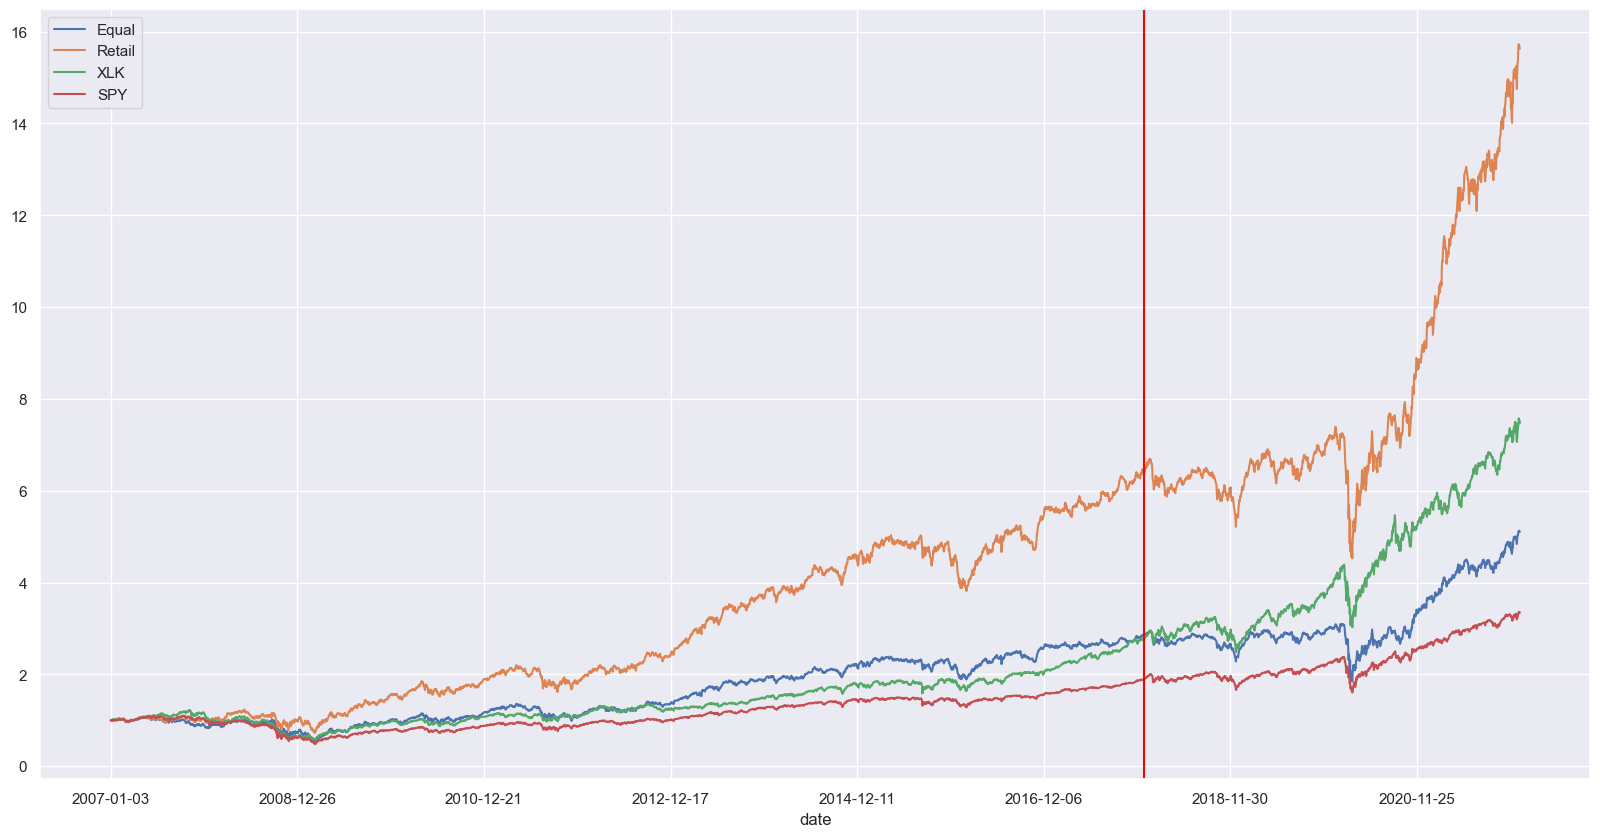

In [160]:
fig, ax = plt.subplots()
dates = data['date'].unique()

# Equal
equal_cum_ret = pd.DataFrame({'date': dates, 'ret': equal_asset_memory}) 
equal_cum_ret['ret'] = equal_cum_ret['ret'] / equal_cum_ret['ret'].loc[0]
ax = equal_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Equal")

# # Mean Variance
# mean_var_cum_ret['date'] = selected_cum_ret['date'].unique()
# ax = mean_var_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Mean Var")

# Retail
retail_cum_ret = pd.DataFrame({'date': dates, 'ret': retail_asset_memory}) 
retail_cum_ret['ret'] = retail_cum_ret['ret'] / retail_cum_ret['ret'].loc[0]
ax = retail_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Retail")

# XLK
ax = yf_xlk.plot(ax=ax, kind='line', x='date', y='ret', label="XLK")

# SPY
ax = yf_spy.plot(ax=ax, kind='line', x='date', y='ret', label="SPY")

ax.axvline(x=np.where(dates == MID_DATE)[0][0], color = 'red')
plt.show()

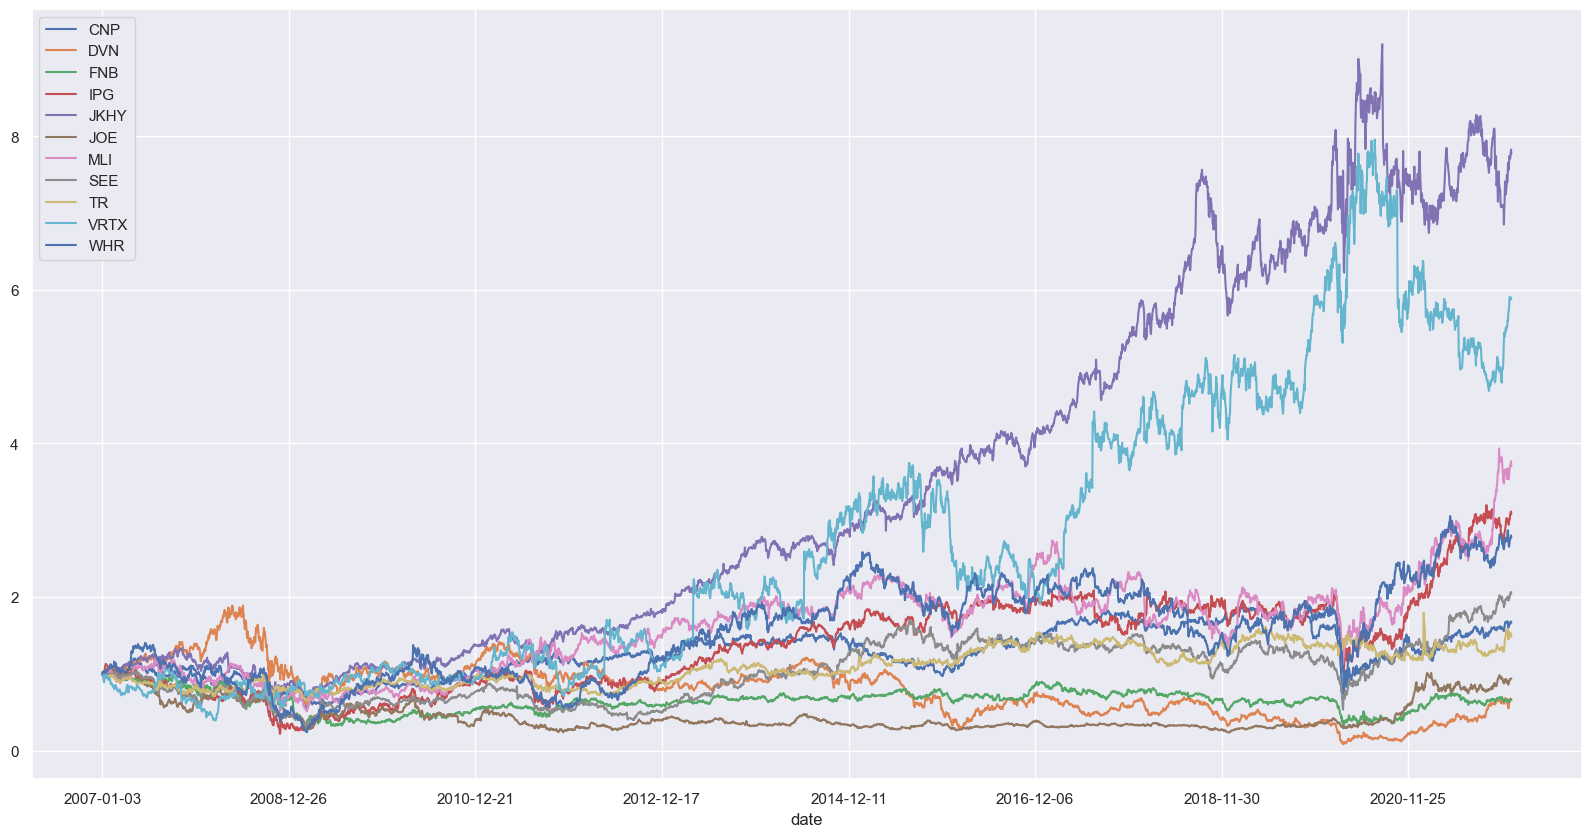

In [161]:
fig, ax = plt.subplots()

# 个股
for key, grp in selected_cum_ret.groupby(['tic']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='open', label=key)
    
plt.show()

### Backtesting

In [162]:
def backtest_helper(ret):
    df = ret.copy()
    df['account_value'] = df['ret']
    perf_stats_all = backtest_stats(df)

In [163]:
backtest_helper(retail_cum_ret)

Annual return          0.201
Cumulative returns    14.632
Annual volatility      0.250
Sharpe ratio           0.858
Calmar ratio           0.489
Stability              0.955
Max drawdown          -0.411
Omega ratio            1.175
Sortino ratio          1.259
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.003
Daily value at risk   -0.031
dtype: float64


In [164]:
backtest_helper(equal_cum_ret)

Annual return          0.115
Cumulative returns     4.107
Annual volatility      0.248
Sharpe ratio           0.563
Calmar ratio           0.226
Stability              0.916
Max drawdown          -0.509
Omega ratio            1.113
Sortino ratio          0.808
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.980
Daily value at risk   -0.031
dtype: float64


In [165]:
backtest_helper(yf_spy)

Annual return          0.084
Cumulative returns     2.344
Annual volatility      0.194
Sharpe ratio           0.513
Calmar ratio           0.148
Stability              0.857
Max drawdown          -0.567
Omega ratio            1.105
Sortino ratio          0.710
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.899
Daily value at risk   -0.024
dtype: float64
